In [1]:
import gym
from keras import models
from keras import layers
from keras.optimizers import Adam
from collections import deque
import random
import numpy as np
!pip install pyglet
import pyglet
from IPython.display import display, clear_output

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 964 kB 4.2 MB/s 


In [2]:
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [3]:
%pip install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.3 MB 155 kB/s 


In [9]:
esp=[]
maxpos=[]
rewards=[]
class MountainCarTrain:
    def __init__(self,env):
        self.env=env
        self.gamma=0.99

        self.epsilon = 1
        self.epsilon_decay = 0.05

        self.epsilon_min=0.01


        self.learingRate=0.001

        self.replayBuffer=deque(maxlen=20000)
        self.trainNetwork=models.load_model('trainNetworkInEPS129.h5')

        self.episodeNum=10

        self.iterationNum=201 #max is 200

        self.numPickFromBuffer=32

        self.targetNetwork=self.createNetwork()

        self.targetNetwork.set_weights(self.trainNetwork.get_weights())

    def createNetwork(self):
        model = models.Sequential()
        state_shape = self.env.observation_space.shape

        model.add(layers.Dense(24, activation='relu', input_shape=state_shape))
        model.add(layers.Dense(48, activation='relu'))
        model.add(layers.Dense(self.env.action_space.n,activation='linear'))
        # model.compile(optimizer=optimizers.RMSprop(lr=self.learingRate), loss=losses.mean_squared_error)
        model.compile(loss='mse', optimizer=Adam(lr=self.learingRate))
        return model

    def getBestAction(self,state):

        self.epsilon = max(self.epsilon_min, self.epsilon)

        if np.random.rand(1) < self.epsilon:
            # Make a random action (exploration)
            action = np.random.randint(0, 3)
        else:
            # Get action from Q-network (exploitation)
            # Estimate the Qs values state
            # Take the biggest Q value (= the best action)
            Q=self.trainNetwork.predict(state)[0]
            action=np.argmax(Q)

        return action



    def trainFromBuffer_Boost(self):
        if len(self.replayBuffer) < self.numPickFromBuffer:
            return
        samples = random.sample(self.replayBuffer,self.numPickFromBuffer)
        npsamples = np.array(samples)
        states_temp, actions_temp, rewards_temp, newstates_temp, dones_temp = np.hsplit(npsamples, 5)
        states = np.concatenate((np.squeeze(states_temp[:])), axis = 0)
        rewards = rewards_temp.reshape(self.numPickFromBuffer,).astype(float)
        targets = self.trainNetwork.predict(states)
        newstates = np.concatenate(np.concatenate(newstates_temp))
        dones = np.concatenate(dones_temp).astype(bool)
        notdones = ~dones
        notdones = notdones.astype(float)
        dones = dones.astype(float)
        Q_futures = self.targetNetwork.predict(newstates).max(axis = 1)
        targets[(np.arange(self.numPickFromBuffer), actions_temp.reshape(self.numPickFromBuffer,).astype(int))] = rewards * dones + (rewards + Q_futures * self.gamma)*notdones
        self.trainNetwork.fit(states, targets, epochs=1, verbose=0)



    def trainFromBuffer(self):
        if len(self.replayBuffer) < self.numPickFromBuffer:
            return

        samples = random.sample(self.replayBuffer,self.numPickFromBuffer)

        states = []
        newStates=[]
        for sample in samples:
            state, action, reward, new_state, done = sample
            states.append(state)
            newStates.append(new_state)

        newArray = np.array(states)
        states = newArray.reshape(self.numPickFromBuffer, 2)

        newArray2 = np.array(newStates)
        newStates = newArray2.reshape(self.numPickFromBuffer, 2)

        targets = self.trainNetwork.predict(states)
        new_state_targets=self.targetNetwork.predict(newStates)

        i=0
        for sample in samples:
            #extract data from the buffer
            state, action, reward, new_state, done = sample 
            target = targets[i]
            if done:
                #refer to the algo
                target[action] = reward
            else:
                Q_future = max(new_state_targets[i])
                 # refer to the algo
                target[action] = reward + Q_future * self.gamma
            i+=1

        self.trainNetwork.fit(states, targets, epochs=1, verbose=0)


    def orginalTry(self,currentState,eps):
        print(eps)
        rewardSum = 0
        max_position=-99
        

        for i in range(self.iterationNum):
            print(i)
            bestAction = self.getBestAction(currentState)

            #show the animation every 50 eps
            if eps%50==0:
                env.render()

            new_state, reward, done, _ = env.step(bestAction)

            new_state = new_state.reshape(1, 2)

            # # Keep track of max position
            if new_state[0][0] > max_position:
                max_position = new_state[0][0]


            # # Adjust reward for task completion
            if new_state[0][0] >= 0.5:
                reward += 10

            self.replayBuffer.append([currentState, bestAction, reward, new_state, done])

            #Or you can use self.trainFromBuffer_Boost(), it is a matrix wise version for boosting
            self.trainFromBuffer()

            rewardSum += reward

            currentState = new_state

            if done:
                break
        

        if i >= 199:
            print("Failed to finish task in epsoide {}".format(eps))
        else:
            print("Success in epsoide {}, used {} iterations!".format(eps, i))
            self.trainNetwork.save('./trainNetworkInEPS{}.h5'.format(eps))

        #Sync
        if eps%5==0:
            self.targetNetwork.set_weights(self.trainNetwork.get_weights())
        esp.append(max(self.epsilon_min, self.epsilon))
        rewards.append(rewardSum)
        maxpos.append(max_position)
        

        print("now epsilon is {}, the reward is {} maxPosition is {}".format(max(self.epsilon_min, self.epsilon), rewardSum,max_position))
        self.epsilon -= self.epsilon_decay
        clear_output(wait = True)

    def start(self):
        for eps in range(self.episodeNum):
            currentState=env.reset().reshape(1,2)
            self.orginalTry(currentState, eps)


env = gym.make('MountainCar-v0')
dqn = MountainCarTrain(env=env)
#target_net = MountainCarTrain(env=env)
#target_net.set_weights(policy_net.get_weights()
dqn.start()


9
0
1/1 [==============================] - 0s 24ms/step
1
1/1 [==============================] - 0s 24ms/step
2
1/1 [==============================] - 0s 20ms/step
3
1/1 [==============================] - 0s 23ms/step
4
1/1 [==============================] - 0s 22ms/step
5
1/1 [==============================] - 0s 26ms/step
6
1/1 [==============================] - 0s 26ms/step
7
1/1 [==============================] - 0s 23ms/step
8
1/1 [==============================] - 0s 26ms/step
9
1/1 [==============================] - 0s 20ms/step
10
1/1 [==============================] - 0s 25ms/step
11
1/1 [==============================] - 0s 23ms/step
12
1/1 [==============================] - 0s 22ms/step
13
1/1 [==============================] - 0s 23ms/step
14
1/1 [==============================] - 0s 22ms/step
15
1/1 [==============================] - 0s 24ms/step
16
1/1 [==============================] - 0s 25ms/step
17
1/1 [==============================] - 0s 24ms/step
18
1/1 [==========

In [10]:
env = gym.make('MountainCar-v0')

#play 20 times
#load the network
model=models.load_model('trainNetworkInEPS129.h5')
r_list=[]
for i_episode in range(20):
    currentState = env.reset().reshape(1, 2)

    print("============================================")

    rewardSum=0
    rewards1=[]
    for t in range(200):
        env.render()
        action = np.argmax(model.predict(currentState)[0])

        new_state, reward, done, info = env.step(action)

        new_state = new_state.reshape(1, 2)

        currentState=new_state

        rewardSum+=reward
        rewards1.append(rewardSum)
        if done:
            print("Episode finished after {} timesteps reward is {}".format(t+1,rewardSum))
            r_list.append(rewards1)
            clear_output(wait = True)
            break


1/1 [==============================] - 0s 23ms/step
Episode finished after 200 timesteps reward is -200.0


Text(0.5, 0, 'Runs')

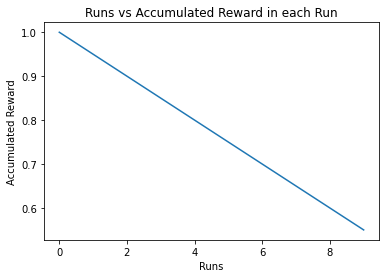

In [11]:
import matplotlib.pyplot as plt
plt.plot(range(len(esp)), esp)
plt.title("Runs vs Accumulated Reward in each Run")
plt.ylabel("Accumulated Reward")
plt.xlabel("Runs")

Text(0.5, 0, 'Runs')

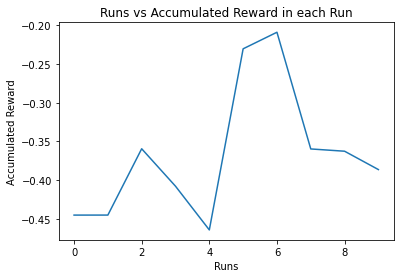

In [12]:
plt.plot(range(len(maxpos)), maxpos)
plt.title("Runs vs Accumulated Reward in each Run")
plt.ylabel("Accumulated Reward")
plt.xlabel("Runs")

Text(0.5, 0, 'Runs')

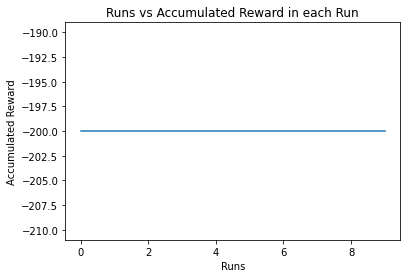

In [13]:
plt.plot(range(len(rewards)), rewards)
plt.title("Runs vs Accumulated Reward in each Run")
plt.ylabel("Accumulated Reward")
plt.xlabel("Runs")